In [86]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp
from dataclasses import field
from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from typing import Tuple, Hashable, Mapping, Dict

import mimetypes
import abc
from abc import abstractmethod, abstractproperty


In [100]:
import functools

# CIFAR subset data

First we want to view our data to check if everything is how we expect it to be.

## Setup

In [10]:
DATA_PATH = Path('../data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

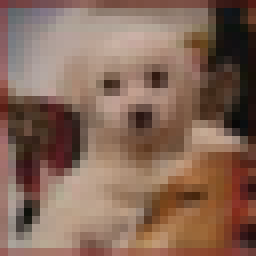

In [11]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = PIL.Image.open(dog_fn)
dog_image.resize((256,256))

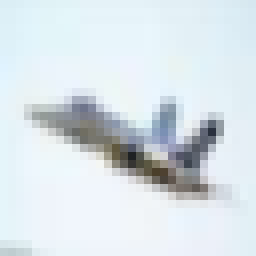

In [12]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = PIL.Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

We will build a Dataset class for our image files. A Dataset class needs to have two functions: length and get-item. Our FilesDataset additionally gets the image files from their respective directories and transforms them to tensors.

In [31]:
list((TRAIN_PATH).iterdir())
list((TRAIN_PATH).iterdir())[0].is_dir()

[PosixPath('../data/cifar10_dog_air/train/dog'),
 PosixPath('../data/cifar10_dog_air/train/airplane')]

True

In [13]:
#export
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style. Image size is (channel,h,w)"
    # convert float tensor (between 0 and 1) back to normal picture (0 to 255, height x width x channels)
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res

def show_image(img:Tensor, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, 
               title:Optional[str]=None, cmap:str='binary', alpha:Optional[float]=None)->plt.Axes:
    "Plot tensor `img` using matplotlib axis `ax`.  `figsize`,`axis`,`title`,`cmap` and `alpha` pass to `ax.imshow`"
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    if title: ax.set_title(title)
    return ax

In [14]:
class Image():
    '''
    To include show_image function into image
    '''
    def __init__(self, px): self.px = px # type tensor
    def show(self, ax=None, **kwargs): return show_image(self.px, ax=ax, **kwargs)
    @property
    def data(self): return self.px

In [15]:
#export
FilePathList = Collection[Path]
TensorImage = Tensor
NPImage = np.ndarray

def find_classes(folder:Path)->FilePathList:
    "Return class subdirectories in imagenet style train `folder`"
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/')) # get other image type (.jpg, ...)

def get_image_files(c:Path, check_ext:bool=True)->FilePathList:
    "Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`."
    return [o for o in list(c.iterdir())
            if not (o.name.startswith('.') or o.is_dir()
            or (check_ext and o.suffix not in image_extensions))]

def pil2tensor(image:NPImage)->TensorImage:
    "Convert PIL style `image` array to torch style image tensor `get_image_files`"
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1) # height x width x channels
    return arr.permute(2,0,1) # channels x height x width

PathOrStr = Union[Path,str]
def open_image(fn:PathOrStr):
    "Return `Image` object created from image in file `fn`"
    x = PIL.Image.open(fn).convert('RGB') # should return PIL.Image.Image type
    return Image(pil2tensor(x).float().div_(255)) # normalize between 0 and 1

In [75]:
image_extensions

{'.bmp',
 '.gif',
 '.ico',
 '.ief',
 '.jpe',
 '.jpeg',
 '.jpg',
 '.pbm',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.ras',
 '.rgb',
 '.svg',
 '.tif',
 '.tiff',
 '.xbm',
 '.xpm',
 '.xwd'}

In [16]:
find_classes(PATH)

[WindowsPath('../data/cifar10_dog_air/test'),
 WindowsPath('../data/cifar10_dog_air/train')]

In [17]:
get_image_files(TRAIN_PATH/'dog')[:5]

[WindowsPath('../data/cifar10_dog_air/train/dog/10014_dog.png'),
 WindowsPath('../data/cifar10_dog_air/train/dog/10033_dog.png'),
 WindowsPath('../data/cifar10_dog_air/train/dog/10060_dog.png'),
 WindowsPath('../data/cifar10_dog_air/train/dog/10072_dog.png'),
 WindowsPath('../data/cifar10_dog_air/train/dog/10082_dog.png')]

In [19]:
path_temp=get_image_files(TRAIN_PATH/'dog')[0]
str(path_temp)

'..\\data\\cifar10_dog_air\\train\\dog\\10014_dog.png'

In [20]:
img_temp=open_image(path_temp)

'torch.FloatTensor'

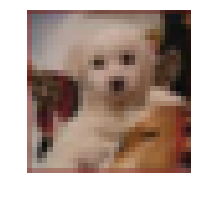

In [21]:
img_temp.data.type()
img_temp.show()

In [22]:
#export
NPArrayableList = Collection[Union[np.ndarray, list]]
NPArrayMask = np.ndarray
SplitArrayList = List[Tuple[np.ndarray,np.ndarray]]

def arrays_split(mask:NPArrayMask, *arrs:NPArrayableList)->SplitArrayList:
    "Given `arrs` is [a,b,...] and `mask`index - return[(a[mask],a[~mask]),(b[mask],b[~mask]),...]"
    mask = array(mask)
    return list(zip(*[(a[mask],a[~mask]) for a in map(np.array, arrs)]))

def random_split(valid_pct:float, *arrs:NPArrayableList)->SplitArrayList:
    "Randomly `array_split` with `valid_pct` ratio. good for creating validation set."
    is_train = np.random.uniform(size=(len(arrs[0]),)) > valid_pct
    return arrays_split(is_train, *arrs)

class DatasetBase(Dataset):
    "Base class for all fastai datasets"
    def __len__(self): return len(self.x)
    @property
    def c(self): 
        "Number of classes expressed by dataset y variable"
        return self.y.shape[-1] if len(self.y.shape)>1 else 1
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

class LabelDataset(DatasetBase):
    "Base class for fastai datasets that do classification"
    @property
    def c(self): 
        "Number of classes expressed by dataset y variable"
        return len(self.classes)

In [76]:
??Dataset

In [36]:
#export
ImgLabel = str
ImgLabels = Collection[ImgLabel]
Classes = Collection[Any]

class FilesDataset(LabelDataset):
    "Dataset for folders of images in style {folder}/{class}/{images}"
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Classes]=None):
        self.classes = ifnone(classes, list(set(labels)))
        self.class2idx = {v:k for k,v in enumerate(self.classes)}
        self.x = np.array(fns)
        self.y = np.array([self.class2idx[o] for o in labels], dtype=np.int64)
    
    def __getitem__(self,i): return open_image(self.x[i]),self.y[i]
    
    @staticmethod
    def _folder_files(folder:Path, label:ImgLabel, check_ext=True)->Tuple[FilePathList,ImgLabels]:
        "From `folder` return image files and labels. The labels are all `label`. `check_ext` means only image files"
        fnames = get_image_files(folder, check_ext=check_ext)
        return fnames,[label]*len(fnames)
    
    @classmethod
    def from_single_folder(cls, folder:PathOrStr, classes:Classes, check_ext=True):
        "Typically used for test set. label all images in `folder` with `classes[0]`"
        fns,labels = cls._folder_files(folder, classes[0], check_ext=check_ext)
        return cls(fns, labels, classes=classes)

    @classmethod
    def from_folder(cls, folder:Path, classes:Optional[Classes]=None, 
                    valid_pct:float=0., check_ext:bool=True) -> Union['FilesDataset', List['FilesDataset']]:
        "Dataset of `classes` labeled images in `folder`. Optional `valid_pct` split validation set."
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns,labels = [],[]
        for cl in classes:
            f,l = cls._folder_files(folder/cl, cl, check_ext=check_ext)
            fns+=f; labels+=l
            
        if valid_pct==0.: return cls(fns, labels, classes=classes)
        return [cls(*a, classes=classes) for a in random_split(valid_pct, fns, labels)]

In [73]:
sd(FilesDataset.from_folder)

<a id=from_folder></a>**from_folder**(<em>cls</em>, <em>folder</em>: Path, <em>classes</em>: typing.Union[typing.Collection[typing.Any], NoneType]=None, <em>valid_pct</em>: float=0.0, <em>check_ext</em>: bool=True) -> typing.Union[ForwardRef('FilesDataset'), typing.List[ForwardRef('FilesDataset')]]


Dataset of `classes` labeled images in `folder`. Optional `valid_pct` split validation set.

In [24]:
train_ds = FilesDataset.from_folder(PATH/'train')
valid_ds = FilesDataset.from_folder(PATH/'test')

In [25]:
train_ds.x[:5]
train_ds.y[:5]

array([WindowsPath('../data/cifar10_dog_air/train/airplane/10008_airplane.png'),
       WindowsPath('../data/cifar10_dog_air/train/airplane/10010_airplane.png'),
       WindowsPath('../data/cifar10_dog_air/train/airplane/10020_airplane.png'),
       WindowsPath('../data/cifar10_dog_air/train/airplane/10024_airplane.png'),
       WindowsPath('../data/cifar10_dog_air/train/airplane/10031_airplane.png')],
      dtype=object)

array([0, 0, 0, 0, 0], dtype=int64)

In [26]:
train_ds.classes
train_ds.class2idx

['airplane', 'dog']

{'airplane': 0, 'dog': 1}

In [27]:
train_ds.c

2

In [97]:
train_ds[0]

(Image (torch.Size([3, 32, 32])), 0)

In [28]:
train_ds[0][0].data

tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

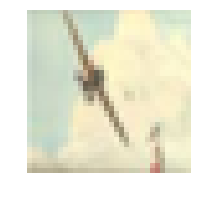

In [100]:
train_ds[0][0].show()

# Data augmentation

Now we are going augment our data to increase our training set. We will start by changing the brightness and contrast of our images.

Brightness is computed by taking the logit of the change and adding it to the logit of the images pixels. Finally we take the sigmoid of the result.

Contrast is computed by simply multiplying pixel values by the scale.

## Lighting

We will start by changing the brightness and contrast of our images.

## Method
### Brightness

Brightness refers to where does our image stand on the dark-light spectrum. Brightness is applied by adding a positive constant to each of the image's channels. This works because each of the channels in an image goes from 0 (darkest) to 255 (brightest) in a dark-light continum. (0, 0, 0) is black (total abscence of light) and (255, 255, 255) is white (pure light). You can check how this works by experimenting by yourself here.

Parameters

Change How much brightness do we want to add to (or take from) the image.

$C \in \mathbb{R}$

### Contrast

Contrast refers to how sharp a distinction there is between brighter and darker sections of our image. To increase contrast we need darker pixels to be darker and lighter pixels to be lighter. In other words, we would like channels with a value smaller than 128 to decrease and channels with a value of greater than 128 to increase.

Parameters

Scale How much contrast do we want to add to (or remove from) the image.

$C \in [0, inf]$

### On logit and sigmoid

Notice that for both transformations we first apply the logit to our tensor (convert x: 0 to 1 to x: -inf to inf), then apply the transformation (add constant to x for brightness or multiply constant to x for contrast) and finally take the sigmoid (back to x: 0 and 1). This is important for two reasons.

First, we don't want to overflow our tensor values. In other words, we need our final tensor values to be $T_{ij} \in [0,1]$. Imagine, for instance, a tensor value at 0.99. We want to increase its brightness, but we can’t go over 1.0. By doing logit first, which first moves our space to $-inf$ to $+inf$, this works fine. The same applies to contrast if we have a scale S >1 (might make some of our tensor values greater than one).

Second, when we apply contrast, we need to affect the dispersion (state of being spread over an area) of values around the middle value. Say we want to increase contrast. Then we need the bright values (>0.5) to get brighter and dark values (<0.5) to get darker. We must first transform our tensor values so our values which were originally <0.5 are now negative and our values which were originally >0.5 are positive. This way, when we multiply by a constant, the dispersion around 0 will increase (small numbers around 0 * positive scale = small numbers => they don't change much?). The logit function does exactly this and allows us to increase or decrease dispersion around a mid value.

In [28]:
??partial

# return a new function with fewer parameters and fixed values set for the original function

In [78]:
def multiply(x,y,z):
        return 3*x + 2*y + z
func1 = partial(multiply,3)
print(func1(2,1))

func2 = partial(multiply,3,2)
print(func2(1))

14
14


In [29]:
def logit(x:Tensor)->Tensor:  return -(1/x-1).log()
def logit_(x:Tensor)->Tensor: return (x.reciprocal_().sub_(1)).log_().neg_() # -log(1/x -1)

In [30]:
#export
FlowField = Tensor
LogitTensorImage = TensorImage
AffineMatrix = Tensor
KWArgs = Dict[str,Any]
ArgStar = Collection[Any]
TensorImageSize = Tuple[int,int,int]

LightingFunc = Callable[[LogitTensorImage, ArgStar, KWArgs], LogitTensorImage]
PixelFunc = Callable[[TensorImage, ArgStar, KWArgs], TensorImage]
CoordFunc = Callable[[FlowField, TensorImageSize, ArgStar, KWArgs], LogitTensorImage]
AffineFunc = Callable[[KWArgs], AffineMatrix]


class ItemBase():
    "All transformable dataset items use this type"
    @property
    @abstractmethod
    def device(self): pass
    @property
    @abstractmethod
    def data(self): pass

class ImageBase(ItemBase):
    "Img based `Dataset` items derive from this. Subclass to handle lighting, pixel, etc"
    def lighting(self, func:LightingFunc, *args, **kwargs)->'ImageBase': return self
    def pixel(self, func:PixelFunc, *args, **kwargs)->'ImageBase': return self
    def coord(self, func:CoordFunc, *args, **kwargs)->'ImageBase': return self
    def affine(self, func:AffineFunc, *args, **kwargs)->'ImageBase': return self

    def set_sample(self, **kwargs)->'ImageBase':
        "Set parameters that control how we `grid_sample` the image after transforms are applied"
        self.sample_kwargs = kwargs
        return self
    
    def clone(self)->'ImageBase': 
        "Clones this item and its `data`"
        return self.__class__(self.data.clone())

Old Image class
```
class Image():
    '''
    To include show_image function into image
    '''
    def __init__(self, px): self.px = px # type tensor
    def show(self, ax=None, **kwargs): return show_image(self.px, ax=ax, **kwargs)
    @property
    def data(self): return self.px
```

In [56]:
class Image(ImageBase):
    "Supports appying transforms to image data"
    def __init__(self, px)->'Image':
        "create from raw tensor image data `px`"
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    @property
    def shape(self)->Tuple[int,int,int]: 
        "Returns (ch, h, w) for this image"
        return self._px.shape
    @property
    def size(self)->Tuple[int,int]: 
        "Returns (h, w) for this image"
        return self.shape[-2:]
    @property
    def device(self)->torch.device: return self._px.device
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.shape})'

    def refresh(self)->None:
        "Applies any logit or affine transfers that have been "
        # This is called when self.px is called, mostly from self.data and self.show
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_() # sigmoid logit_px and save back to px
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            self._px = grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self)->TensorImage:
        "Get the tensor pixel buffer"
        self.refresh()
        return self._px
    @px.setter
    def px(self,v:TensorImage)->None: 
        "Set the pixel buffer to `v`"
        self._px=v

    @property
    def flow(self)->FlowField:
        "Access the flow-field grid after applying queued affine transforms"
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow
    
    @flow.setter
    def flow(self,v:FlowField): self._flow=v

    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image':
        "Equivalent to `image = sigmoid(func(logit(image)))`"
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func:PixelFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.px = func(image.px)`"
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func:CoordFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.flow = func(image.flow, image.size)`"        
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func:AffineFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.affine_mat = image.affine_mat @ func()`"        
        m = tensor(func(*args, **kwargs)).to(self.device)
        self.affine_mat = self.affine_mat @ m
        return self

    def resize(self, size:Union[int,TensorImageSize])->'Image':
        "Resize the image to `size`, size can be a single int"
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self)->AffineMatrix:
        "Get the affine matrix that will be applied by `refresh`"
        if self._affine_mat is None:
            self._affine_mat = torch.eye(3).to(self.device)
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v)->None: self._affine_mat=v

    @property
    def logit_px(self)->LogitTensorImage:
        "Get logit(image.px)"
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v:LogitTensorImage)->None: self._logit_px=v
    
    def show(self, ax:plt.Axes=None, **kwargs:Any)->None: 
        "Plots the image into `ax`"
        show_image(self.px, ax=ax, **kwargs)
    
    @property
    def data(self)->TensorImage: 
        "Returns this images pixels as a tensor"
        return self.px

In [38]:
def contrast(x:Tensor, scale:float)->Tensor: return x.mul_(scale)

In [39]:
train_ds = FilesDataset.from_folder(PATH/'train')
valid_ds = FilesDataset.from_folder(PATH/'test')

In [40]:
x = lambda: train_ds[1][0] # to avoid transform the tensor permanently
x()

Image (torch.Size([3, 32, 32]))

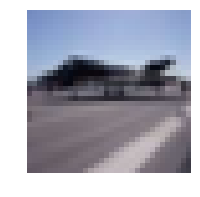

In [52]:
img = x()
x().show()

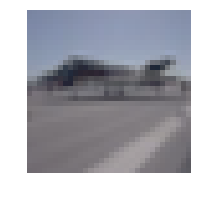

In [53]:
img.logit_px = contrast(img.logit_px, 0.5)
img.show()

In [46]:
from IPython.core.debugger import set_trace

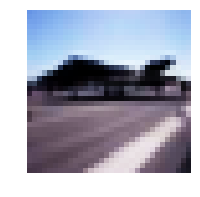

In [57]:
x().lighting(contrast, 2).show()

## Decorator and composition

We are interested in composing the transform functions so as to apply them all at once. We will try to feed a list of transforms to our pipeline for it to apply all of them.

Applying a function to our transforms before calling them in Python is easiest if we use a decorator. You can find more about decorators here.

Function decorators: wrappers to existing functions, to add new functionality to existing functions

In [61]:
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

get_text = p_decorate(get_text)

print(get_text("John"))

<p>lorem ipsum, John dolor sit amet</p>


In [62]:
# using decorator:
def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

def div_decorate(func):
    def func_wrapper(name):
        return "<div>{0}</div>".format(func(name))
    return func_wrapper
@p_decorate
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)
@p_decorate
def get_another_text(name):
    return "YO, {0} IS DOPE".format(name)

print (get_text("John"))
print(get_another_text("John"))

@div_decorate
@p_decorate
def get_another_text2(name):
    return "YO, {0} IS DOPE".format(name)
print(get_another_text2('John'))

<p>lorem ipsum, John dolor sit amet</p>
<p>YO, John IS DOPE</p>
<div><p>YO, John IS DOPE</p></div>


In [159]:
# PythonDecorators/my_decorator.py
class my_decorator(object):

    def __init__(self, f):
        print("inside my_decorator.__init__()")
        self.f = f
#         f() # Prove that function definition has completed

    def __call__(self, *args,**kwargs):
        print("inside my_decorator.__call__()")
        print(args)
        print(kwargs)
        self.f(*args,**kwargs)

@my_decorator
def aFunction(x,y=1):
    print("inside aFunction() with arg "+str(x)+ " and kwarg " + str(y))

print("Finished decorating aFunction()")

inside my_decorator.__init__()
Finished decorating aFunction()


In [160]:
aFunction(3)

inside my_decorator.__call__()
(3,)
{}
inside aFunction() with arg 3 and kwarg 1


In [161]:
aFunction(3,4)

inside my_decorator.__call__()
(3, 4)
{}
inside aFunction() with arg 3 and kwarg 4


In [162]:
aFunction(x=3,y=4)

inside my_decorator.__call__()
()
{'x': 3, 'y': 4}
inside aFunction() with arg 3 and kwarg 4


## Transform class

In [58]:
class Transform():
    _wrap=None
    def __init__(self, func): self.func=func
    def __call__(self, x, *args, **kwargs):
        if self._wrap:
            # if _wrap is 'lighting', it will call x.lighting, which essentially do func(logit(x),*args, **kwargs) 
            # and return the Image obj itself
            return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          
            return self.func(x, *args, **kwargs)
    
class TfmLighting(Transform): _wrap='lighting'

In [60]:
@TfmLighting
def brightness(x, change): 
    # the change to be added to x for brightness should be between 0 and 1, as it will be transformed using logit
    # Note that x in here is already logit
    return x.add_(scipy.special.logit(change))
@TfmLighting
def contrast(x, scale): 
    return x.mul_(scale)

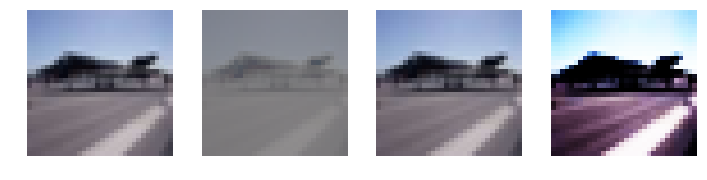

In [78]:

_,axes = plt.subplots(1,4, figsize=(12,3))

x().show(axes[0])
contrast(x(), 0.2).show(axes[1])
contrast(x(), 1).show(axes[2])
contrast(x(), 4).show(axes[3])

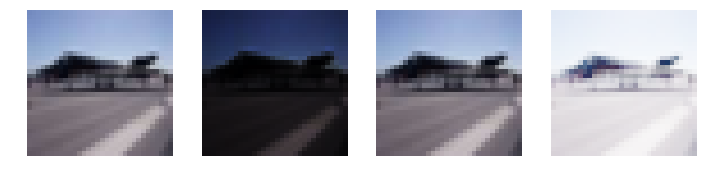

In [79]:
_,axes = plt.subplots(1,4, figsize=(12,3))

x().show(axes[0])
brightness(x(), 0.1).show(axes[1])
brightness(x(), 0.5).show(axes[2])
brightness(x(), 0.9).show(axes[3])

In [76]:
def brightness_contrast(x, scale_contrast, change_brightness):
    return brightness(contrast(x, scale=scale_contrast), change=change_brightness)

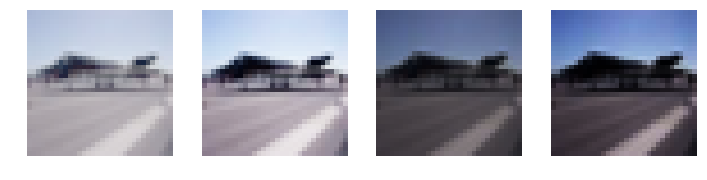

In [80]:
_,axes = plt.subplots(1,4, figsize=(12,3))

brightness_contrast(x(), 0.75, 0.7).show(axes[0]) # less contrast,  brighter
brightness_contrast(x(), 1.3,  0.7).show(axes[1])# more contrast, brighter
brightness_contrast(x(), 0.75,0.3).show(axes[2]) # less contrast, dimmer
brightness_contrast(x(), 1.3, 0.3).show(axes[3]) # more contrast, dimmer

## Random lighting

Next, we will make our previous transforms random since we are interested in automatizing the transforms pipeline. We will achieve this by making our parameters stochastic with a specific distribution: uniform for brightness and log_uniform for contrast.

We will use a *uniform* distribution for brightness change since its domain is the real numbers and the impact varies linearly with the scale. For contrast we use *log_uniform* for two reasons. First, contrast scale has a domain of [0, inf]. Second, the impact of the scale in the transformation is non-linear (i.e. 0.5 is as extreme as 2.0, 0.2 is as extreme as 5). The log_uniform function is appropriate because it has the same domain and correctly represents the non-linearity of the transform, P(0.5) = P(2).

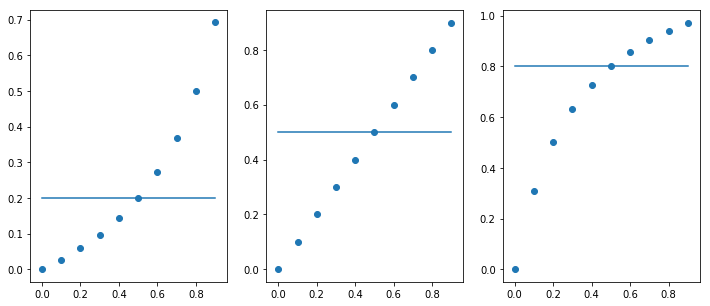

In [88]:
# brightness impact varies linearly with scale
def logit(x):  return scipy.special.logit(x)
def sigmoid(x): return 1 / (1+np.e**(-x))
fig,axes = plt.subplots(1,3,figsize=(12,5))
pixel=0.2
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[0].plot(brightness,[pixel]*len(brightness))
axes[0].scatter(brightness,pixel_r)

pixel=0.5
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[1].plot(brightness,[pixel]*len(brightness))
axes[1].scatter(brightness,pixel_r)

pixel=0.8
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[2].plot(brightness,[pixel]*len(brightness))
axes[2].scatter(brightness,pixel_r)

Dim pixels are insensitive to small brightness change, but very sensitive to large brightness change

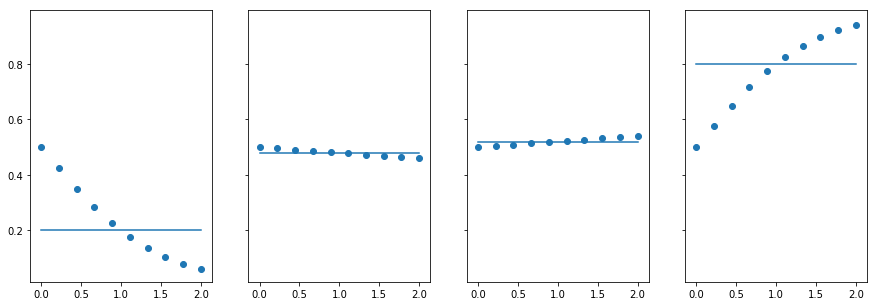

In [85]:
# contrast scales affect pixel differently

fig,axes = plt.subplots(1,4,figsize=(15,5),sharey=True)

pixel=0.2
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[0].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[0].scatter(contrast_scale,pixel_r)

pixel=0.48
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[1].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[1].scatter(contrast_scale,pixel_r)

pixel=0.52
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[2].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[2].scatter(contrast_scale,pixel_r)

pixel=0.8
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[3].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[3].scatter(contrast_scale,pixel_r)

Dim pixel gets dimmer when scale increases. ~0.5 pixel does not change much

In [89]:
#export
FloatOrTensor = Union[float,Tensor]
BoolOrTensor = Union[bool,Tensor]
def uniform(low:Number, high:Number, size:List[int]=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=`low`, max=`high`"
    return random.uniform(low,high) if size is None else torch.FloatTensor(*listify(size)).uniform_(low,high)

def log_uniform(low, high, size=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=log(`low`), max=log(`high`)"
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p:float, size=None)->BoolOrTensor: 
    "Draw 1 or shape=`size` random booleans (True occuring probability p)"
    return uniform(0,1,size)<p

In [90]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

0.997911225059048

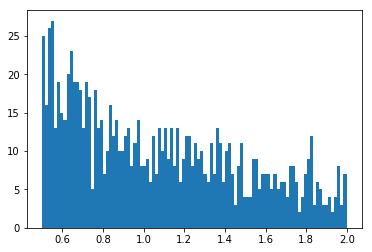

In [91]:
# log uniform distribution
log_u = [log_uniform(0.5,2.0) for _ in range(1000)]
plt.hist(log_u,bins=100);

In [92]:
#export
import inspect
from copy import copy,deepcopy

def get_default_args(func:Callable):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

ListOrItem = Union[Collection[Any],int,float,str]
OptListOrItem = Optional[ListOrItem]
def listify(p:OptListOrItem=None, q:OptListOrItem=None):
    "Makes `p` same length as `q`"
    # duplicate single-item list p q times
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

In [17]:
# def compose(funcs):
#     # funcs is list of partial functions. Execute this list of functions in order
#     # compose acts as a wrapper for multiple PARTIAL functions in funcs list
#     def _inner(x, *args, **kwargs):
#         for f in listify(funcs): x = f(x, *args, **kwargs)
#         return x
#     return _inner if funcs else None

In [95]:
listify((2),3)
listify(2,[3,4])
listify([2,3],3)

[2, 2, 2]

[2, 2]

[2, 3]

AssertionError: List len mismatch (2 vs 3)

Old transform class
```
class Transform():
    _wrap=None
    def __init__(self, func): self.func=func
    def __call__(self, x, *args, **kwargs):
        if self._wrap:
            # if _wrap is 'lighting', it will call x.lighting, which essentially do func(logit(x),*args, **kwargs) 
            # and return the Image obj itself
            return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          
            return self.func(x, *args, **kwargs)
    
class TfmLighting(Transform): _wrap='lighting'
```


In [165]:
class Transform():
    "Utility class for adding probability and wrapping support to transform funcs"
    _wrap=None
    order=0
    def __init__(self, func:Callable, order:Optional[int]=None)->None:
        "Create a transform for `func` and assign it an priority `order`, attach to Image class"
        if order is not None: self.order=order
        self.func=func
        functools.update_wrapper(self, self.func)
        self.func.__annotations__['return'] = Image
        self.params = copy(func.__annotations__)
        self.def_args = get_default_args(func)
        setattr(Image, func.__name__,
                lambda x, *args, **kwargs: self.calc(x, *args, **kwargs))
        
    def __call__(self, *args:Any, p:float=1., is_random:bool=True, **kwargs:Any)->Image:
        "Calc now if `args` passed; else create a transform called prob `p` if `random`"
#         set_trace()
        if args: return self.calc(*args, **kwargs)
        else: return RandTransform(self, kwargs=kwargs, is_random=is_random, p=p)
        
    def calc(self, x:Image, *args:Any, **kwargs:Any)->Image:
        "Apply this transform to image `x`, wrapping it if necessary"
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          return self.func(x, *args, **kwargs)

    @property
    def name(self)->str: return self.__class__.__name__
    
    def __repr__(self)->str: return f'{self.name} ({self.func.__name__})'

class TfmLighting(Transform): order,_wrap = 8,'lighting' #order = 8,_wrap='lighting'

In [164]:
@dataclass
class RandTransform():
    "Wraps `Transform` to add randomized execution"
    tfm:Transform
    kwargs:dict
    p:int=1.0
    resolved:dict = field(default_factory=dict)
    do_run:bool = True
    is_random:bool = True
    def __post_init__(self): functools.update_wrapper(self, self.tfm)
    
    def resolve(self)->None:
        "Bind any random variables needed tfm calc"
#         set_trace()
        if not self.is_random:
            self.resolved = {**self.tfm.def_args, **self.kwargs}
            return

        self.resolved = {}
        # for each param passed to tfm...
        for k,v in self.kwargs.items():
            # ...if it's annotated, call that fn...
            if k in self.tfm.params:
                rand_func = self.tfm.params[k]
                self.resolved[k] = rand_func(*listify(v))
            # ...otherwise use the value directly
            else: self.resolved[k] = v
        # use defaults for any args not filled in yet
        for k,v in self.tfm.def_args.items():
            if k not in self.resolved: self.resolved[k]=v
        # anything left over must be callable without params
        for k,v in self.tfm.params.items():
            if k not in self.resolved and k!='return': self.resolved[k]=v()

        self.do_run = rand_bool(self.p)

    @property
    def order(self)->int: return self.tfm.order

    def __call__(self, x:Image, *args, **kwargs)->Image:
        "Randomly execute our tfm on `x`"
        return self.tfm(x, *args, **{**self.resolved, **kwargs}) if self.do_run else x

In [166]:
#export
@TfmLighting
def brightness(x, change:uniform): 
    "`change` brightness of image `x`"
    return x.add_(scipy.special.logit(change))

@TfmLighting
def contrast(x, scale:log_uniform): 
    "`scale` contrast of image `x`"
    return x.mul_(scale)

In [167]:
x = lambda: train_ds[1][0] # to avoid transform the tensor permanently
x()

Image (torch.Size([3, 32, 32]))

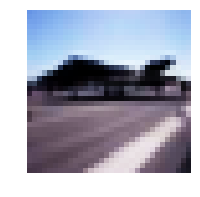

In [138]:
x().contrast(scale=2).show() #???

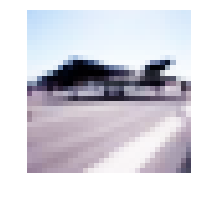

In [139]:
x().contrast(scale=2).brightness(0.8).show()

In [182]:
tfm = contrast(scale=(0.3,3))
tfm.resolve() # generate random var, depends on what type of transformation it is
tfm,tfm.resolved,tfm.do_run

(RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.3, 3)}, p=1.0, resolved={'scale': 1.3373982271013822}, do_run=True, is_random=True),
 {'scale': 1.3373982271013822},
 True)

{'scale': 0.7290273359616578}

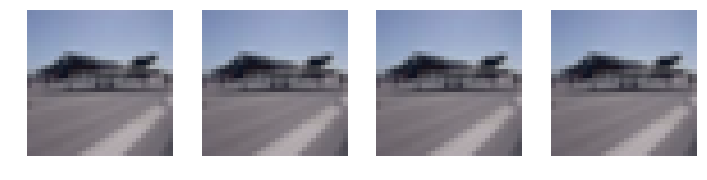

In [185]:
# all the same
tfm.resolve()
tfm.resolved
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: tfm(x()).show(ax)

{'scale': 1.3229491914141818}
{'scale': 0.3917918766481811}
{'scale': 0.7652178431856428}
{'scale': 0.8619417744221174}


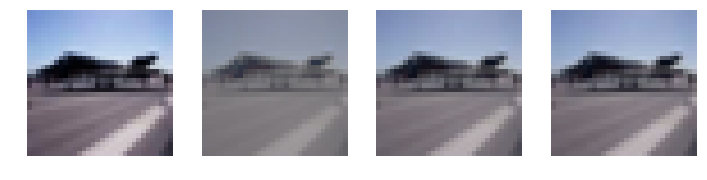

In [188]:
# all different
tfm = contrast(scale=(0.3,3))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    print(tfm.resolved)
    tfm(x()).show(ax)

{'scale': 2}

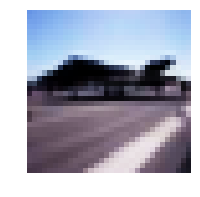

In [194]:
#fix scale
tfm = contrast(scale=2, is_random=False)
tfm.resolve()
tfm.resolved
tfm(x()).show()

## Skip affine. Get to coord and pixel next

In [19]:
# explaining compose function
def show_stuff(x,k1=42,k2='yolo'):
    print(x)
    print(k1)
    print(k2)
def wrap(func): # passing in a partial function
    def inner(*args,**kwargs): # since func remember its fixed parameter, 
        #its wrapper, inner, will also get these fixed parameters
        func(*args,**kwargs)        
    return inner

func3 = partial(show_stuff,k2='YOLO BIATCH') # func3 already remember its fixed parameter here
wrap(func3)(3)

3
42
YOLO BIATCH


In [108]:
def func1(a,b,c:int,d='temp'):
    pass
get_default_args(func1)

{'d': 'temp'}

In [26]:
# #export
# import inspect
# from copy import copy,deepcopy

# def get_default_args(func):
#     return {k: v.default
#             for k, v in inspect.signature(func).parameters.items()
#             if v.default is not inspect.Parameter.empty}

# class Transform():
#     def __init__(self, func, p=1., **kwargs):
# #         set_trace()
#         # func is the lowest-level tfm function, i.e contrast. Not partial. Input parameters: x (tensor) and a constant (scale)
#         self.func,self.p,self.kw = func,p,kwargs #self.kw is a dict {tfm_param : (low,high)}, i,e {'scale':(0.3,5)}
#         self.def_args = get_default_args(func) # get tfm default param in dic {tfm_param: constant}, i.e {'scale':1}
#         self.params = copy(func.__annotations__)
#         # i.e for contrast, self.params should be  {'scale': <func to get random scale from log distribution b/t low and high>}
#         self.params.pop('return') 
#     @property
#     def name(self): return self.__class__.__name__ # a getter
    
#     def __repr__(self):
#         return f'{self.func.__name__}_tfm->{self.name}; {self.kw} (p={self.p})'

#     def resolve(self):
#         # either get a constant from random distribution or other use case?
#         self.resolved = {}
#         for k,v in self.params.items():
#             if k not in self.kw and k in self.def_args: 
#                 # if there is a default param for tfm but it's not specified in self.kw
#                 # TODO: use case for this? Probably when user wants a specific scale for transformation
#                 self.resolved[k] = self.def_args[k]
#             else: 
#                 # k in self.kw or k not in self.def_args
#                 # i.e, right hand side will be log_uniform(*(low,high))
#                 # self.resolved is {'scale': random constant between low and high}
#                 self.resolved[k] = v(*listify(self.kw[k]))
#         self.do_run = rand_bool(self.p) # boolean, True or False

#     def __call__(self, x, *args, **kwargs): # function call operator. Called when running tfm = Transform(...); tfm(...)
#         #execute the lowest-level transform function on x
#         #for contrast example, only kwargs are passed
#         return self.func(x, *args, **self.resolved, **kwargs) if self.do_run else x
    
#     def apply(self, tfms=None):
#         if tfms is None: 
#             # if there is no other tfm is passed, use self (the Transform class itself) as a function (__call__ wil be used)
#             tfms=self
#         # execute multiple low-level tfms using compose func. Return transformed x. resolve should be called first?
#         return compose(tfms)

# class TfmLighting(Transform):
#     def apply(self, tfms=None): 
#         # do the logit -> tfm func -> sigmoid for lighting
#         return apply_lighting(super().apply(tfms))

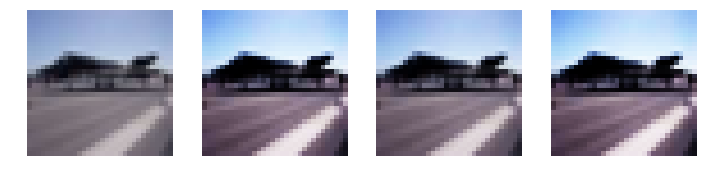

In [121]:
tfm = contrast_tfm(scale=(0.3,3), p=0.5)

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve() # whenever this is called, scale gets another random constant is drawed
    show_image(apply_lighting(tfm)(x()), ax)

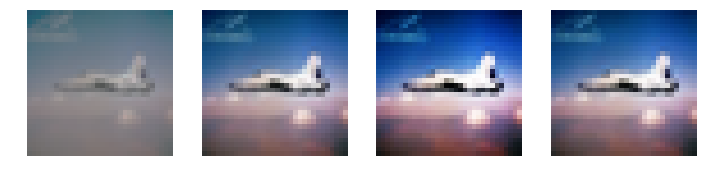

In [34]:
tfm = contrast_tfm(scale=(0.3,3), p=1)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    show_image(apply_lighting(tfm)(x()), ax)

In [24]:
#export
def reg_transform(func):
    tfm = partial(func.__annotations__['return'], func)
    
    # change partial function name func_tfm
    setattr(sys.modules[func.__module__], f'{func.__name__}_tfm', tfm)
    return func

@reg_transform
def brightness(x, change:uniform) ->TfmLighting: return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale:log_uniform)->TfmLighting: return x.mul_(scale)



In [25]:
def resolve_tfms(tfms):
    for f in listify(tfms): f.resolve()

def _apply_tfms(x,tfms):
    if not tfms: return x
    resolve_tfms(tfms) #make sure to 'resolve' (draw a constant from uniform distribution)
#     for f in tfms:
#         print(f.resolved,f.do_run)

    # this is just odd... tfms[0], which is a TfmLighting CLASS, receive a list of other TfmLightingClass into its apply function
    return tfms[0].apply(tfms)(x.clone()) 
    

def apply_tfms(tfms): return partial(_apply_tfms, tfms=tfms)

In [175]:
??TfmLighting.apply

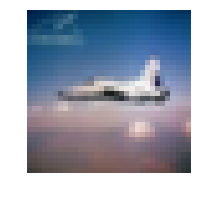

In [90]:
x = train_ds[1][0]
show_image(x)
#original

In [174]:
??Transform.apply

In [172]:
??_apply_tfms

{'scale': 0.5121735213889604} True
{'change': 0.4860031621506206} False
{'scale': 1.415747509162914} False
{'change': 0.5454761543557511} True
{'scale': 2.111201629710358} True
{'change': 0.5393430382163225} False
{'scale': 1.421424921538738} False
{'change': 0.35442093801055985} False


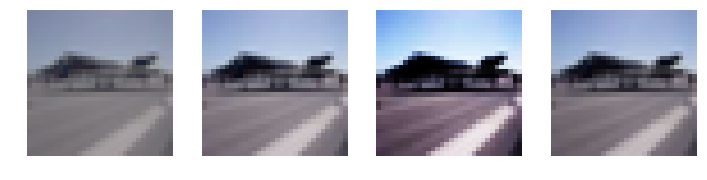

In [171]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=0.5),
        brightness_tfm(change=(0.35,0.65), p=0.5)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)
# transform image x 4 times with p=1, independently

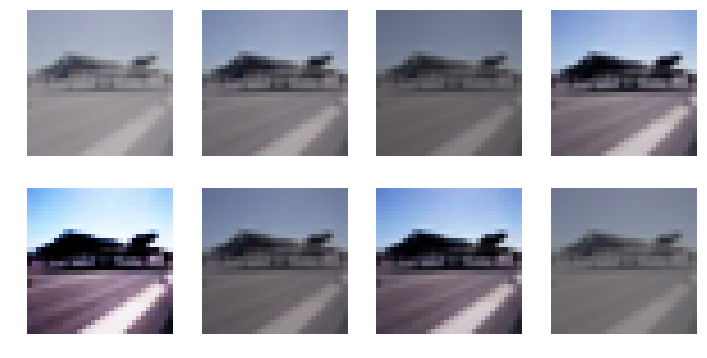

In [180]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=1),
        brightness_tfm(change=(0.35,0.65), p=1)]

_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x), axes[0][i])
    show_image(tfm(x), axes[1][i])

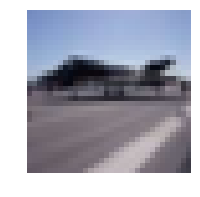

In [181]:
show_image(apply_tfms([])(x)) # no transformation

# Affine

## Deterministic affine

In [88]:
#export
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [87]:
#export
def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    '''
    Given an input and a flow-field grid, 
    computes the output using input pixel locations from the grid.
    '''
    if padding_mode=='reflect': padding_mode='reflection'
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(x, matrix, size=None):
    '''
    Generates a 2d flow field, given a batch of affine matrices theta.
    Generally used in conjunction with grid_sample() to implement Spatial Transformer Networks.
    '''
    if size is None: size = x.size()
    elif isinstance(size, int): size=(x.size(0), size, size)
    return F.affine_grid(matrix[None,:2,:], # 3x3 to N x 2 x 3 (N=1)
                         torch.Size((1,)+size)) # N x channel x h x w
    # return tensor of size N x h x w x 2

In [91]:
def rotate(degrees):
    angle = degrees * math.pi / 180 # to radian
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [89]:
torch.Size((1,)+x.size())

torch.Size([1, 3, 32, 32])

In [65]:
m = rotate(10)
m = x.new_tensor(m)
m.type()
m.shape

'torch.FloatTensor'

torch.Size([3, 3])

In [79]:
c = affine_grid(x, m)
c.size()

torch.Size([1, 32, 32, 2])

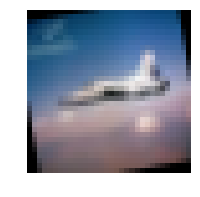

In [76]:
# c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

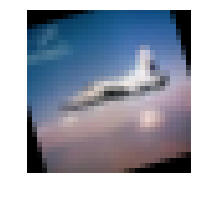

In [35]:
m = rotate(16)
m = x.new_tensor(m)
c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

In [92]:
#export
def affines_mat(img, matrices=None):
    matrices = [img.new_tensor(m) for m in matrices if m is not None]
    if not matrices: return None
    return reduce(torch.matmul, matrices, torch.eye(3))

def affine_mult(c,m):
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)

def _apply_affine(c, size=None, mats=None, func=None, **kwargs):
    return affine_mult(c, affines_mat(c, mats))

def apply_affine(mats): return partial(_apply_affine, mats=mats)

def affine_only(x, mats, size=None, **kwargs):
    tfm = apply_affine(mats)
    c = affine_grid(x, torch.eye(3), size=size)
    c = tfm(c)
    return grid_sample(x, c, **kwargs)

In [93]:
img2 = affine_only(x, [rotate(30)])
show_image(img2)

ValueError: padding_mode needs to be 'zeros' or 'border', but got reflection

In [94]:
def zoom(scale: uniform, row_pct=0.5, col_pct=0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

In [96]:
show_image(affine_only(x, [zoom(0.6)]))

ValueError: padding_mode needs to be 'zeros' or 'border', but got reflection